In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
# all modules/dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [12]:
data_dir = "data_transfer"

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.Resize(size=(152,152)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.Resize(size=(152,152)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}


In [13]:
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

In [14]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

{'train': 777, 'validation': 256}
cpu


In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

In [7]:
import torch.nn as nn
import torch.nn.functional as F
train_on_gpu = torch.cuda.is_available()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 5)
        #self.relu = nn.ReLU()
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(128*32*32, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 2)

        
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = x.view(-1, 128 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = F.softmax(F.relu(self.fc3(x)))
        return x

# create a complete CNN
model = Net()

model = model.to(device)

print(model)

# move tensors to GPU if CUDA is available


Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout(p=0.2)
  (fc1): Linear(in_features=131072, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=2, bias=True)
)


In [0]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, 'model_facial_custom_cnn_v3.pt')
    
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum= 0.9)

model = model.to(device)

model = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.6898 Acc: 0.5438
validation Loss: 0.6958 Acc: 0.5000

Epoch 1/49
----------
train Loss: 0.6869 Acc: 0.5438
validation Loss: 0.6927 Acc: 0.5000

Epoch 2/49
----------
train Loss: 0.6799 Acc: 0.5529
validation Loss: 0.6789 Acc: 0.5575

Epoch 3/49
----------
train Loss: 0.6432 Acc: 0.6253
validation Loss: 0.6316 Acc: 0.7188

Epoch 4/49
----------
train Loss: 0.6919 Acc: 0.4616
validation Loss: 0.6931 Acc: 0.5000

Epoch 5/49
----------
train Loss: 0.6931 Acc: 0.4562
validation Loss: 0.6931 Acc: 0.5000

Epoch 6/49
----------
train Loss: 0.6931 Acc: 0.4569
validation Loss: 0.6931 Acc: 0.5006

Epoch 7/49
----------
train Loss: 0.6602 Acc: 0.5750
validation Loss: 0.6241 Acc: 0.6863

Epoch 8/49
----------
train Loss: 0.5992 Acc: 0.7205
validation Loss: 0.6285 Acc: 0.7181

Epoch 9/49
----------
train Loss: 0.5986 Acc: 0.7220
validation Loss: 0.6305 Acc: 0.6794

Epoch 10/49
----------
train Loss: 0.5866 Acc: 0.7385
validation Loss: 0.6062 Acc: 0.7406

Epoch 11/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


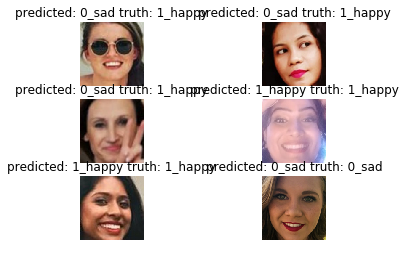

In [0]:
visualize_model(model)

In [0]:
#torch.save(model.state_dict(), 'model_facial_custom_cnn_v2.pt')

In [0]:
checkpoint = {'model': Net(),
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict()}

torch.save(checkpoint, 'checkpoint.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [9]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location='cpu')
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint('checkpoint.pth')

In [0]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 5, 5])
conv1.bias 	 torch.Size([16])
conv2.weight 	 torch.Size([32, 16, 5, 5])
conv2.bias 	 torch.Size([32])
conv3.weight 	 torch.Size([64, 32, 5, 5])
conv3.bias 	 torch.Size([64])
conv4.weight 	 torch.Size([128, 64, 5, 5])
conv4.bias 	 torch.Size([128])
fc1.weight 	 torch.Size([2048, 131072])
fc1.bias 	 torch.Size([2048])
fc2.weight 	 torch.Size([512, 2048])
fc2.bias 	 torch.Size([512])
fc3.weight 	 torch.Size([2, 512])
fc3.bias 	 torch.Size([2])


In [0]:
data_path = "../content/gdrive/My Drive/new_data/train"
data_dir_list = os.listdir(data_path)
print(data_dir_list)

['1_happy', '0_sad']


In [0]:
import cv2
n = 0
img_data=[]

dataset = '1_happy'

img_list=os.listdir(data_path+'/'+ dataset)
print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
for img in img_list:
    input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
    input_img_resize=cv2.resize(input_img,(152,152))
    img_data.append(input_img_resize)
    n = n + 1
    if (n>=200):
        break



Loaded the images of dataset-1_happy



In [0]:
dataset = '0_sad'
n = 0       
img_list=os.listdir(data_path+'/'+ dataset)
print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
for img in img_list:
    input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
    input_img_resize=cv2.resize(input_img,(152,152))
    img_data.append(input_img_resize)
    n = n + 1
    if (n>=200):
        break
    
                
img_data = np.array(img_data)

Loaded the images of dataset-0_sad



In [0]:
img_data.shape

(400, 152, 152, 3)

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

#data transformation
trans = transforms.Compose([
       transforms.ToPILImage(),
       transforms.Resize(size=(152,152)),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)])



In [0]:
img_data_tensor = trans(img_data[0])

In [0]:
image = img_data_tensor.unsqueeze(0)

In [0]:
image.shape

torch.Size([1, 3, 152, 152])

In [0]:
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    a = model(image)[0]

In [0]:
a

tensor([1.9402, 7.5780])

In [0]:
outputs

tensor([[1.9402, 7.5780]])

In [0]:
def images_to_sprite(data):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxW[x3] tensor containing the images.
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
    # Inverting the colors seems to look better for MNIST
    #data = 1 - data

    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0),
            (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',
            constant_values=0)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3)
            + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 152).astype(np.uint8)
    return data

sprite = images_to_sprite(img_data)


In [0]:
cv2.imwrite('../content/sprite_4_classes.png', sprite)

True

In [0]:
def get_image_features(im):
    image_features = np.zeros((1, 2))
    im = trans(im)
    im = im.unsqueeze(0)
    image_features[0,:] = model(im)[0]
    return image_features

In [0]:
image_features_list=[]



for img in img_data:
    image_features=get_image_features(img)
    image_features_list.append(image_features)
    
    


In [0]:
image_features_list[0]

array([[1.94017088, 7.5780344 ]])

In [0]:
image_features_arr=np.asarray(image_features_list)
image_features_arr = np.rollaxis(image_features_arr,1,0)
image_features_arr = image_features_arr[0,:,:]

np.savetxt('feature_vectors_400_samples.txt',image_features_arr)
#feature_vectors = np.loadtxt('feature_vectors.txt')
pickle.dump(image_features_arr, open('feature_vectors_400_samples.pkl', 'wb'))


In [0]:
feature_vectors = np.loadtxt('feature_vectors_400_samples.txt')
print ("feature_vectors_shape:",feature_vectors.shape)
print ("num of images:",feature_vectors.shape[0])
print ("size of individual feature vector:",feature_vectors.shape[1])

num_of_samples=feature_vectors.shape[0]
num_of_samples_each_class = 200

feature_vectors_shape: (400, 2)
num of images: 400
size of individual feature vector: 2


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector

In [0]:
features = tf.Variable(feature_vectors, name='features')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
import numpy as np
y = np.ones((400,),dtype='int64')

y[0:200]=0
y[200:400]=1

names = ['happy','sad']

In [0]:
metadata_file = open('metadata_4_classes.tsv', 'w')
metadata_file.write('Class\tName\n')

11

In [0]:
k = 200
j = 0
for i in range(400):
    c = names[y[i]]
    if i%k==0:
        j=j+1
    metadata_file.write('{}\t{}\n'.format(j,c))
metadata_file.close()

In [0]:
LOG_DIR = '../content/logs'
with tf.Session() as sess:
    saver = tf.train.Saver([features])

    sess.run(features.initializer)
    saver.save(sess, os.path.join(LOG_DIR, 'images_4_classes.ckpt'))

    config = projector.ProjectorConfig()
    # One can add multiple embeddings.
    embedding = config.embeddings.add()
    embedding.tensor_name = features.name
    # Link this tensor to its metadata file (e.g. labels).
    embedding.metadata_path = os.path.join(LOG_DIR, 'metadata_4_classes.tsv')
    # Comment out if you don't want sprites
    embedding.sprite.image_path = os.path.join(LOG_DIR, 'sprite_4_classes.png')
    embedding.sprite.single_image_dim.extend([img_data.shape[1], img_data.shape[1]])
    # Saves a config file that TensorBoard will read during startup.
    projector.visualize_embeddings(tf.summary.FileWriter(LOG_DIR), config)

In [0]:
!zip -r /content/logs.zip /content/logs

  adding: content/logs/ (stored 0%)
  adding: content/logs/images_4_classes.ckpt.index (deflated 36%)
  adding: content/logs/projector_config.pbtxt (deflated 43%)
  adding: content/logs/images_4_classes.ckpt.data-00000-of-00001 (deflated 55%)
  adding: content/logs/images_4_classes.ckpt.meta (deflated 61%)
  adding: content/logs/checkpoint (deflated 41%)


In [10]:
# specify loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs.data, 1)
    a = model(image)[0]

In [15]:
test_losses = [] # for tracking loss

import numpy as np

y_true = []

y_probs = []

y_pred = []

total = 0
correct = 0


# iterate over test data
with torch.no_grad():
    for inputs, labels in dataloaders['validation']:

        # get predicted outputs
        outputs = model(inputs)

        # getting the index of output tensors with max values
        _, classes = torch.max(outputs.data, 1)


        y_true += labels.cpu().numpy().tolist()
        y_probs += classes.cpu().numpy().tolist()
        y_pred += outputs.cpu().detach().tolist()


        # for calculating accuracy
        total += labels.size(0)
        correct += (classes == labels).sum().item() # comparing predictions to true label


        test_loss = criterion(outputs, labels)
        test_losses.append(test_loss.item())
    
print("Test loss: {:.3f}".format(np.mean(test_losses)))    
print('Accuracy of the network on the test data : {:.3f} %'.format((correct / total) * 100))

c:\users\gagan\envs\iim\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Test loss: 0.446
Accuracy of the network on the test data : 85.938 %


In [21]:
emotions = ["happy","sad"]

In [17]:
import sklearn.metrics as metrics

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm =  metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the da
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [18]:
import scikitplot as skplt

In [19]:
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df, fpr, tpr

Confusion matrix, without normalization
Normalized confusion matrix


c:\users\gagan\envs\iim\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


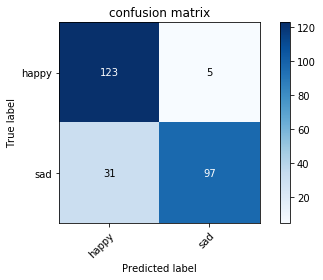

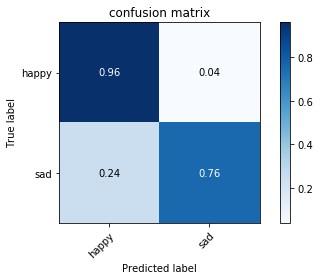

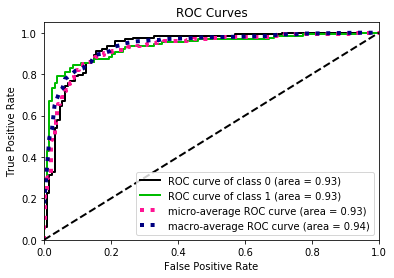

In [22]:
y_true = np.array(y_true)

y_probs = np.array(y_probs)

y_pred = np.array(y_pred)



plot_confusion_matrix(y_true, y_probs, classes=emotions, normalize=False, title='confusion matrix')

plot_confusion_matrix(y_true, y_probs, classes=emotions, normalize=True, title='confusion matrix')

skplt.metrics.plot_roc_curve(y_true, y_pred)
plt.show()

Confusion matrix, without normalization


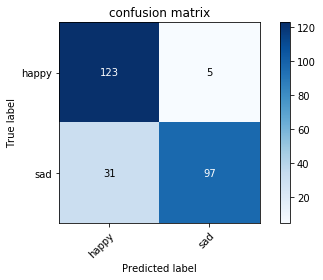

In [24]:
fig2 = plot_confusion_matrix(y_true, y_probs, classes=emotions, normalize=False, title='confusion matrix')
fig2 = fig2.get_figure()
fig2.savefig('confusion_mat_custom_cnn.png', dpi=1440)

c:\users\gagan\envs\iim\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)


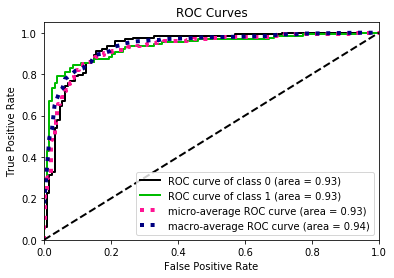

In [25]:
fig = skplt.metrics.plot_roc_curve(y_true, y_pred)
plt.show()
fig = fig.get_figure()
fig.savefig('roc_custom_cnn.png', dpi=1440)